In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os
import sncosmo
import tables
from astropy.time import Time
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# Light curve plot

## Data sources:
 1. P48/CFH12K
 2. P60/SEDm
 3. LCOGT-1m/Sinistro
 4. Swift/UVOT
 
## Filter data:
 1. CFH12K: _g_ and _R_
 2. SEDm: _g_, _r_ and _i_
 
## Data filename:
 ```iPTF16abc.h5```

In [25]:
# load light curve data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table = h5file.root.photometry

lc = {"P48/CFH12K": dict(), "P60/SEDm": dict(), "LCO-1m/Sinistro": dict(), "Swift/UVOT": dict(), "SPM-1.5m/RATIR": dict()}
for filter_name in ["g", "R"]:
    lc["P48/CFH12K"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'P48') & (filter_name == b'%s') & (mag_err < 10)" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["g", "r", "i"]:
    lc["P60/SEDm"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'P60') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["B", "V", "g", "r", "i"]:
    lc["LCO-1m/Sinistro"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'LCO-1m') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["UVW2", "UVM2", "UVW1", "U", "B", "V"]:
    lc["Swift/UVOT"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'Swift') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])

for filter_name in ["r", "i", "Z", "Y", "J", "H"]:
    lc["SPM-1.5m/RATIR"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'SPM-1.5m') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])

spec_epochs = [t.attrs.OBS_DATE for t in h5file.root.spectroscopy]
    

ul = {}
ul["g"] = np.array([(row["time"], -2.5*np.log10(5*row["flux_err"]/3631))
                  for row in table.where(
                      "(telescope == b'P48') & (filter_name == b'g') & (time < 57481.2)")],
                 dtype=[("time", "f"), ("mag_lim", "f")])



h5file.close()

In [211]:
T_MAX = 57499.537694
T_fl = 57481.2
z = 0.0234
colors = {"UVW2": "#D0E1F9",
          "UVM2": "#008DCB",
          "UVW1": "Cyan",
          "U": "DarkBlue",
          "B": "Blue",
          "V": "#68A225", 
          "g": "LightSeaGreen",
          "R": "Crimson", 
          "r": "Crimson",
          "i": "#FFDB5C",
          "Z": "#FE0000",
          "Y": "#882426",
          "J": "#C9A66B",
          "H": "#C5001A"}

markers = {"Swift": "h", 
           "P48": "o",
           "P60": "d",
           "LCO-1m": "s", 
           "SPM-1.5m": "p"}
offsets = {"UVW2": -5,
           "UVM2": -5,
           "UVW1": -1,
           "U": 2,
           "B": -1.5,
           "V": 1,
           "g": 0,
           "R": 2,
           "r": 2,
           "i": 3,
           "Z": 4,
           "Y": 5,
           "J": 6,
           "H": 7}


AAMcolors = {'Ni_models': "#2A3132",
             'g': "LightSeaGreen", 
             'UVW2-V': "#5F9683", # ultramarine
             'UVW1-V': "#00CFAA", # cyan
             'U-V': "#FF0038", # fig
             'B-V': "#012161", # royal blue
             'g-r': "#6599FF", # light blue #F77604", # caviar
             'r-i': "#FF0038",  # ripe tomato
             'i-Z': "#AF4425", # cayene
             'Z-Y': "#662225", # red onion 
             'J-H': "#C9A66B" # cinnamon
             } 



AAMoffsets = {'UVW2-V': 1, # midnight blue
              'UVW1-V': 1, # fig or #50312F eggplant
              'U-V': 2, # blueberry
              'B-V': 1, # yellow pepper
              'g-r': 0, # carrot
              'r-i': -1,  # tomato
              'i-Z': -3, # cinnamon
              'Z-Y': -4, # red onion 
              'J-H': -6 # cayene
             }




In [32]:
# sncosmo
# run sncosmo
# filter data
fp = tables.open_file("filters.h5", mode="r")
filters = dict()
for filter_name in ["g", "R"]:
    filters["P48_" + filter_name] =\
        np.array([(row["wavelength"], row["transmission"])
                  for row in fp.root.P48.CFH12K._f_get_child(filter_name)],
                 dtype=[("wavelength", "f"), ("transmission", "f")])
for filter_name in ["g", "r", "i"]:
    filters["P60_" + filter_name] =\
        np.array([(row["wavelength"], row["transmission"])
                  for row in fp.root.P60.SEDm._f_get_child(filter_name)],
                 dtype=[("wavelength", "f"), ("transmission", "f")])
for key in filters:
    band = sncosmo.Bandpass(filters[key]["wavelength"],
                            filters[key]["transmission"],
                            name=key)
    sncosmo.registry.register(band)
fp.close()

# sncosmo model
dust = sncosmo.F99Dust()
host_dust = sncosmo.F99Dust()
model = sncosmo.Model(source="salt2",
                      effects=[host_dust, dust],
                      effect_names=["host", "mw"],
                      effect_frames=["rest", "obs"])
model.set(z=0.0234)
model.set(t0=T_MAX)
model.set(hostebv=0.05)
model.set(mwebv=0.024)
model.set(x0=0.008604)
model.set(x1=0.964324)
model.set(c=0.033302)

Exception: p48_g already in registry. Use force=True to override.

### Experiment with a log plot for just the g-band light curve

In [33]:
def lc_color(t_blue, m_blue, m_blue_unc, t_red, m_red, m_red_unc, delta_t_merge = 1/24):
    """Return the (merged) color curve for two filters 
    
    Parameters
    ----------
    t_blue : array-like 
        Time array for blue filter measurements
        
    m_blue : array-like, shape = t_blue.shape
        mag array for the blue filter measurements
        
    m_blue_unc : array-like, shape = t_blue.shape
        mag uncertainties array for the blue filter measurements
    
    t_red : array-like
        Time array for red filter measurements
        
    m_red : array-like, shape = t_red.shape
        mag array for the red filter measurements
        
    m_red_unc : array-like, shape = t_red.shape
        mag uncertainties array for the red filter measurements

    delta_t_merge : float, optional (default = 1/24)
    
    Returns
    -------
    t_color : array-like
    
    m_color : array-like
    
    m_color_unc : array-like
    
    """

    if len(t_blue) != len(m_blue) or len(t_blue) != len(m_blue_unc):
        raise ValueError('Length of t_blue, m_blue, and m_blue_unc do not match')

    if len(t_red) != len(m_red) or len(t_red) != len(m_red_unc):
        raise ValueError('Length of t_red, m_red, and m_red_unc do not match')

    t_red = np.ma.array(t_red, mask = np.zeros(t_red.shape))
    m_red = np.ma.array(m_red, mask = np.zeros(m_red.shape))
    m_red_unc = np.ma.array(m_red_unc, mask = np.zeros(m_red_unc.shape))
    
    t_color = np.empty(0)
    m_color = np.empty(0)
    m_color_unc = np.empty(0)
    delta_t_merge = 1/24.
    
    for tb, mb, mbu in zip(t_blue, m_blue, m_blue_unc):
        if np.min(np.abs(t_red - tb)) < delta_t_merge:
            match_idx = np.argmin(np.abs(t_red - tb))
            t_color = np.append(t_color, (tb + t_red[match_idx]) / 2)
            m_color = np.append(m_color, mb - m_red[match_idx] )

            m_color_unc = np.append(m_color_unc, 
                                    np.hypot(mbu, m_red_unc[match_idx]))
            t_red.mask[match_idx] = True
    
    return t_color, m_color, m_color_unc

<IPython.core.display.Javascript object>


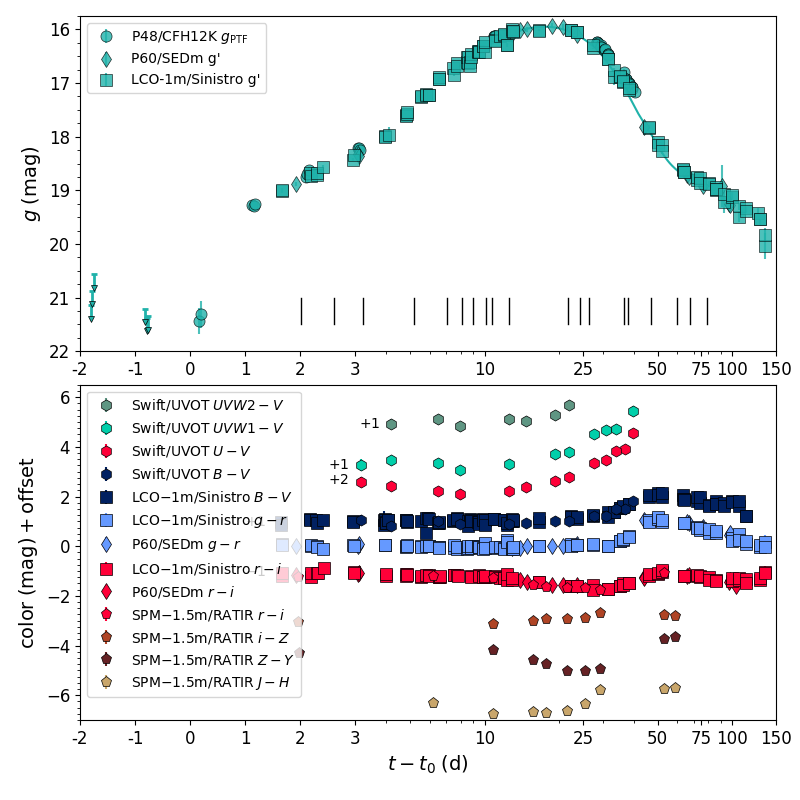

In [53]:
g_filt_dict = {"P48/CFH12K": "$g_\mathrm{PTF}$", "P60/SEDm": "g'", "LCO-1m/Sinistro": "g'"}

fig, (ax, ax2) = plt.subplots(2, 1, sharex = False, figsize=(8,8))
for tel_inst in lc:
    if 'g' in lc[tel_inst].keys():
        tel = tel_inst.split("/")[0]
        inst = tel_inst.split("/")[1]
        curve = lc[tel_inst]['g']
        ax.errorbar((curve["time"] - T_fl)/(1+z) , 
                    curve["mag"] + offsets['g'],
                    yerr=curve["mag_err"], 
                    marker=markers[tel],
                    color=AAMcolors['g'],
                    linestyle='none',
                    mec = 'k',
                    mew = 0.5,
                    ms = 8,
                    alpha=0.8,
                    label="%s %s" % (tel_inst, g_filt_dict[tel_inst]))

t = np.linspace(57489, 57550, 300)
ax.plot((t - T_fl)/(1+z), 
        model.bandmag("P60_g", "ab", t) + offsets["g"], 
        linestyle='-', 
        color=AAMcolors["g"])

for epoch in spec_epochs:
    t = (epoch - T_fl)/(1+z)
    ax.plot([t, t], [21.5, 21], color='k', linewidth=1)

# plot the upper limits
ULoffset = 0.25
yerr_g = np.zeros((2, len(ul['g'])))
yerr_g[0,:] += ULoffset

ax.errorbar((ul['g']['time'] - T_fl)/(1+z), ul['g']['mag_lim']+ULoffset, yerr = yerr_g, 
            fmt = 'v', color = AAMcolors["g"], ms = 5, 
            elinewidth=2, capsize = 0, mec = 'k', mew = 0.5)
ax.plot((ul['g']['time'] - T_fl)/(1+z),ul['g']['mag_lim'], '_', 
        color = AAMcolors["g"], mew = 2, ms = 5)


ax.set_xlim(-2,150)
ax.set_xscale("symlog", linthreshx=3, linscalex = 0.6, subsx = [2,3,4,5,6,7,8,9])
ax.set_ylim(22, 15.75)
ax.set_xticks([-2, -1, 0, 1, 2, 3, 10, 25, 50, 75, 100, 150])
ax.set_xticklabels([-2, -1, 0, 1, 2, 3, 10, 25, 50, 75, 100, 150])
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

# ax.set_xlabel(r"$t - t_0 \; (\mathrm{d})$")
ax.set_ylabel(r"$g \; (\mathrm{mag})$", fontsize = 14)
ax.legend(loc=2)

# plot the color evolution
tel_inst = 'P60/SEDm'

col_dict = {'P60/SEDm': {'bfilts': ['g', 'r'],
                         'rfilts': ['r','i']
                           },
            'LCO-1m/Sinistro': {'bfilts': ['B', 'g', 'r'],
                                  'rfilts': ['V', 'r','i']
                                 },
            'Swift/UVOT': {'bfilts': ['UVW2', 'UVW1', 'U', 'B'],
                           'rfilts': ['V','V','V','V']
                          },
            'SPM-1.5m/RATIR': {'bfilts': ['r', 'i', 'Z', 'J'],
                               'rfilts': ['i', 'Z', 'Y', 'H']
                              }
            }

for tel_inst in col_dict:
    for bf, rf in zip(col_dict[tel_inst]['bfilts'], col_dict[tel_inst]['rfilts']):
        tc, mc, mcu = lc_color(lc[tel_inst][bf]['time'], 
                               lc[tel_inst][bf]['mag'], 
                               lc[tel_inst][bf]['mag_err'], 
                               lc[tel_inst][rf]['time'], 
                               lc[tel_inst][rf]['mag'], 
                               lc[tel_inst][rf]['mag_err'])
        label_txt = r"$\mathrm{{{:s}}} \; {:s} - {:s}$".format(tel_inst.replace("-","\mathrm{-}"), bf, rf)
        ax2.errorbar((tc - T_fl)/(1+z), mc + AAMoffsets[bf + '-' + rf], mcu, 
                     c = AAMcolors[bf + '-' + rf], 
                     fmt = markers[tel_inst.split("/")[0]], 
                     mec = 'k', mew = 0.5, ms = 8,
                     label=label_txt)

ax2.text(3.1, 4.75, r"$+{}$".format(AAMoffsets['UVW2-V']))
ax2.text(2.5, 3.1, r"$+{}$".format(AAMoffsets['UVW1-V']))
ax2.text(2.5, 2.5, r"$+{}$".format(AAMoffsets['U-V']))
ax2.text(1, 0.8, r"$+{}$".format(AAMoffsets['B-V']))
# ax2.text(1.5, 0, r"${}$".format(AAMoffsets['g-r']))
ax2.text(1, -1.2, r"${}$".format(AAMoffsets['r-i']))



ax2.set_xlim(-2,150)
ax2.set_ylim(-7,6.5)
ax2.set_xscale("symlog", linthreshx=3, linscalex = 0.6, subsx = [2,3,4,5,6,7,8,9])

# ax2.set_xscale('log')
ax2.set_ylabel(r'$\mathrm{color \; (mag) + offset}$', fontsize = 14)
ax2.set_xlabel(r'$t - t_0 \; (\mathrm{d})$', fontsize = 14)
ax2.set_xticks([-2, -1, 0, 1, 2, 3, 10, 25, 50, 75, 100, 150])
ax2.set_xticklabels([-2, -1, 0, 1, 2, 3, 10, 25, 50, 75, 100, 150])
ax2.yaxis.set_minor_locator(MultipleLocator(0.25))
for axis in [ax, ax2]:
    axis.tick_params(axis='both', which='major', labelsize=12)

handles, labels = ax2.get_legend_handles_labels()
leg = ax2.legend( [handles[x] for x in [5,6,7,8,2,3,0,4,1, 9, 10, 11, 12]], 
            [labels[x] for x in [5,6,7,8,2,3,0,4,1, 9, 10, 11, 12]], 
            loc = 2, ncol = 1)
# fig.tight_layout()
fig.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.97, top = 0.98, hspace = 0.1)
# plt.savefig('logLC_with_colors.pdf')

<IPython.core.display.Javascript object>


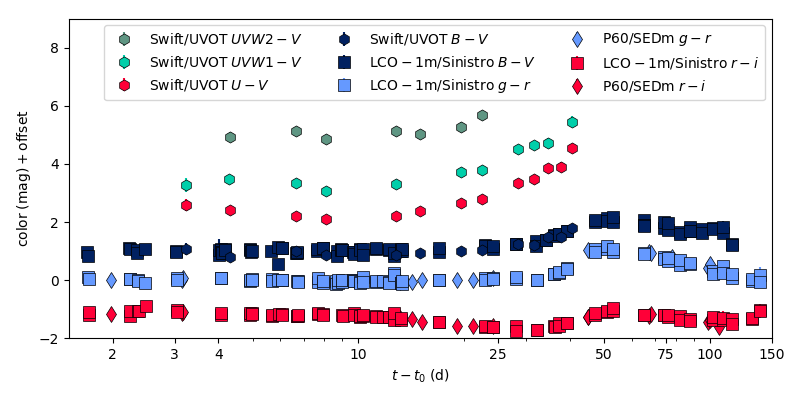

In [54]:
fig, ax2 = plt.subplots(figsize=(8, 4))

tel_inst = 'P60/SEDm'

col_dict = {'P60/SEDm': {'bfilts': ['g', 'r'],
                         'rfilts': ['r','i']
                           },
            'LCO-1m/Sinistro': {'bfilts': ['B', 'g', 'r'],
                                  'rfilts': ['V', 'r','i']
                                 },
            'Swift/UVOT': {'bfilts': ['UVW2', 'UVW1', 'U', 'B'],
                           'rfilts': ['V','V','V','V']
                          }
            }

for tel_inst in col_dict:
    for bf, rf in zip(col_dict[tel_inst]['bfilts'], col_dict[tel_inst]['rfilts']):
        tc, mc, mcu = lc_color(lc[tel_inst][bf]['time'], 
                               lc[tel_inst][bf]['mag'], 
                               lc[tel_inst][bf]['mag_err'], 
                               lc[tel_inst][rf]['time'], 
                               lc[tel_inst][rf]['mag'], 
                               lc[tel_inst][rf]['mag_err'])
        if AAMoffsets[bf + '-' + rf] > 0:
            label_cap = r"$ + {:s}$".format(str(AAMoffsets[bf + '-' + rf]))
        elif AAMoffsets[bf + '-' + rf] < 0:
            label_cap = r"$ - {:s}$".format(str(np.abs(AAMoffsets[bf + '-' + rf])))
        elif AAMoffsets[bf + '-' + rf] == 0:
            label_cap = ""
        label_txt = r"$\mathrm{{{:s}}} \; {:s} - {:s}$".format(tel_inst.replace("_","\mathrm{-}"), bf, rf)
        ax2.errorbar(tc - T_fl, mc + AAMoffsets[bf + '-' + rf], mcu, 
                     c = AAMcolors[bf + '-' + rf], 
                     fmt = markers[tel_inst.split("/")[0]], 
                     mec = 'k', mew = 0.5, ms = 8,
                     label=label_txt)
    

ax2.set_xlim(1.5,150)
ax2.set_ylim(-2,9)
# ax2.set_xscale('symlog', linthreshx=3.5, linscalex = 0.6)
ax2.set_xscale('log')
ax2.set_ylabel(r'$\mathrm{color \; (mag) + offset}$')
ax2.set_xlabel(r'$t - t_0 \; (\mathrm{d})$')
ax2.set_xticks([2, 3, 4, 10, 25, 50, 75, 100, 150])
ax2.set_xticklabels([2, 3, 4, 10, 25, 50, 75, 100, 150])

handles, labels = ax2.get_legend_handles_labels()
ax2.legend( [handles[x] for x in [5,6,7,8,2,3,0,4,1]], 
            [labels[x] for x in [5,6,7,8,2,3,0,4,1]], 
            loc = 1, ncol = 3)
fig.tight_layout()

<IPython.core.display.Javascript object>


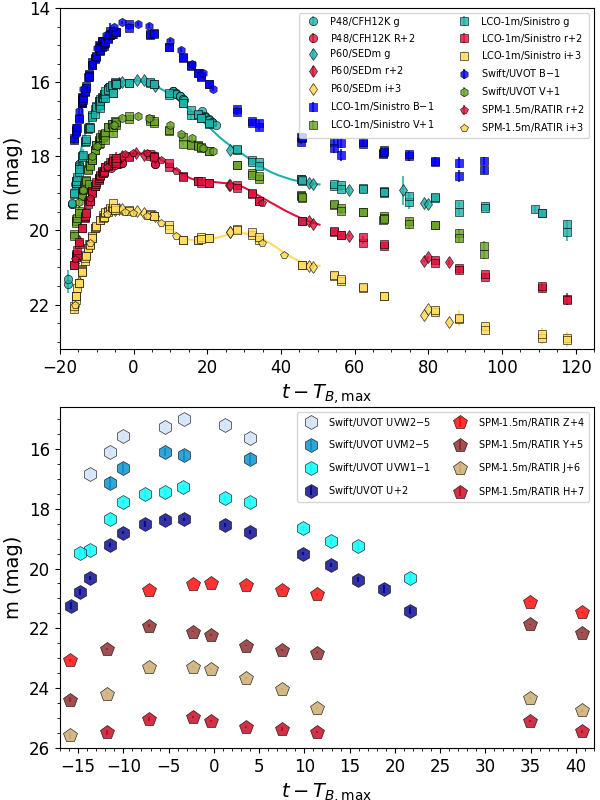

In [223]:
# original fig from Yi

fig, (ax, ax2) = plt.subplots(2,1, figsize=(6, 8))
for tel_inst in lc:
    for filter_name in lc[tel_inst]:
        tel = tel_inst.split("/")[0]
        inst = tel_inst.split("/")[1]
        curve = lc[tel_inst][filter_name]
        if filter_name in ["B", "V", "g", "r", "R", "i"]:
            ax.errorbar((curve["time"] - T_MAX)/(1+z),
                        curve["mag"] + offsets[filter_name],
                        yerr=curve["mag_err"], 
                        marker=markers[tel],
                        color=colors[filter_name],
                        linestyle='none',
                        alpha=0.8,
                        mec = "k", mew = 0.5,
                        label="%s %s" % (tel_inst, filter_name) + ("$%+i$" % offsets[filter_name] if filter_name != "g" else ""))
        else:
            ax2.errorbar((curve["time"] - T_MAX)/(1+z), 
                        curve["mag"] + offsets[filter_name],
                        yerr=curve["mag_err"], 
                        marker=markers[tel],
                        color=colors[filter_name],
                        linestyle='none',
                        alpha=0.8,
                        mec = "k", mew = 0.5, ms = 10,
                        label="%s %s" % (tel_inst, filter_name) + ("$%+i$" % offsets[filter_name] if filter_name != "g" else ""))
            
t = np.linspace(57485, 57550, 300)
for filter_name in ["g", "r", "i"]:
    ax.plot(t - T_MAX, 
            model.bandmag("P60_" + filter_name, "ab", t) + offsets[filter_name], 
            linestyle='-', 
            color=colors[filter_name])

# for epoch in spec_epochs:
#     t = epoch - T_MAX
#     plt.plot([t, t], [12.3, 12.7], color='k', linewidth=1)
        
ax.set_ylim(23.2, 14)
ax.set_xlabel("$t - T_{B,\mathrm{max}}$", fontsize=14)
ax.set_ylabel("m (mag)", fontsize=14)
ax.set_xlim(-20, 125)

ax2.set_ylim(26, 14.6)
ax2.set_xlabel("$t - T_{B,\mathrm{max}}$", fontsize=14)
ax2.set_ylabel("m (mag)", fontsize=14)
ax2.set_xlim(-17, 42)



ax.legend(loc=1, numpoints=1, ncol=2, prop={'size':7}, fancybox=True)
ax2.legend(loc=1, numpoints=1, ncol=2, prop={'size':7}, fancybox=True,labelspacing=1)
for axis in [ax, ax2]:
    axis.tick_params(axis='both', which='major', labelsize=12)
    axis.yaxis.set_minor_locator(MultipleLocator(0.5))
    
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax2.xaxis.set_major_locator(MultipleLocator(5))
ax2.xaxis.set_minor_locator(MultipleLocator(1))

fig.subplots_adjust(left=0.1, right=0.99,top=0.99,bottom=0.065,hspace=0.17)
# fig.savefig("lightcurve.pdf")

<IPython.core.display.Javascript object>


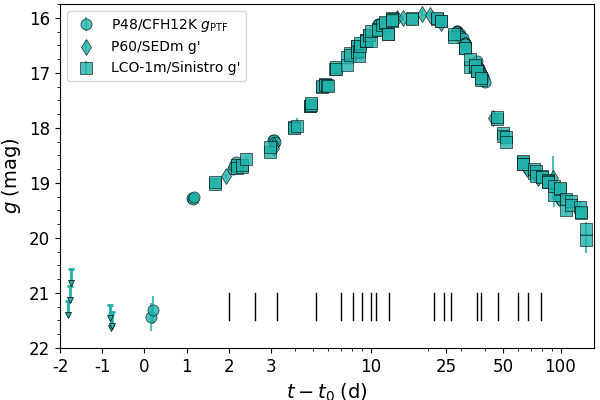

In [227]:
g_filt_dict = {"P48/CFH12K": "$g_\mathrm{PTF}$", "P60/SEDm": "g'", "LCO-1m/Sinistro": "g'"}

fig, (ax) = plt.subplots(1, 1, sharex = False, figsize=(6,4))
for tel_inst in lc:
    if 'g' in lc[tel_inst].keys():
        tel = tel_inst.split("/")[0]
        inst = tel_inst.split("/")[1]
        curve = lc[tel_inst]['g']
        ax.errorbar((curve["time"] - T_fl)/(1+z) , 
                    curve["mag"] + offsets['g'],
                    yerr=curve["mag_err"], 
                    marker=markers[tel],
                    color=AAMcolors['g'],
                    linestyle='none',
                    mec = 'k',
                    mew = 0.5,
                    ms = 8,
                    alpha=0.8,
                    label="%s %s" % (tel_inst, g_filt_dict[tel_inst]))

# t = np.linspace(57489, 57550, 300)
# ax.plot((t - T_fl)/(1+z), 
#         model.bandmag("P60_g", "ab", t) + offsets["g"], 
#         linestyle='-', 
#         color=AAMcolors["g"])

for epoch in spec_epochs:
    t = (epoch - T_fl)/(1+z)
    ax.plot([t, t], [21.5, 21], color='k', linewidth=1)

# plot the upper limits
ULoffset = 0.25
yerr_g = np.zeros((2, len(ul['g'])))
yerr_g[0,:] += ULoffset

ax.errorbar((ul['g']['time'] - T_fl)/(1+z), ul['g']['mag_lim']+ULoffset, yerr = yerr_g, 
            fmt = 'v', color = AAMcolors["g"], ms = 5, 
            elinewidth=2, capsize = 0, mec = 'k', mew = 0.5)
ax.plot((ul['g']['time'] - T_fl)/(1+z),ul['g']['mag_lim'], '_', 
        color = AAMcolors["g"], mew = 2, ms = 5)


ax.set_xlim(-2,150)
ax.set_xscale("symlog", linthreshx=3, linscalex = 0.6, subsx = [2,3,4,5,6,7,8,9])
ax.set_ylim(22, 15.75)
ax.set_xticks([-2, -1, 0, 1, 2, 3, 10, 25, 50, 100])
ax.set_xticklabels([-2, -1, 0, 1, 2, 3, 10, 25, 50, 100])
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

ax.set_xlabel(r"$t - t_0 \; (\mathrm{d})$", fontsize = 14)
ax.set_ylabel(r"$g \; (\mathrm{mag})$", fontsize = 14)
ax.legend(loc=2)
ax.tick_params(axis='both', which='major', labelsize=12)

# fig.tight_layout()
fig.subplots_adjust(left = 0.1, bottom = 0.13, right = 0.99, top = 0.99)
# plt.savefig('logLC_with_colors.pdf')

# Spectra data

## Data sources:
 1. Gemini-N GMOS
 2. DCT DeVeny
 3. LCOGT-2m FLOYDS
 4. Keck-II DEIMOS
 5. Keck-I LRIS
 6. NOT ALFOSC
 7. High-resolution data will be presented in a separate figure

In [228]:
class Spectroscopy(object):
    
    def __init__(self, MJD, telescope, instrument, data):
        self.MJD = MJD
        self.telescope = telescope
        self.instrument = instrument
        self.data = data
        idx = np.logical_and(self.data["wavelength"] > 6000,
                             self.data["wavelength"] < 7000)
        self.data["flux"] /= np.median(self.data["flux"][idx])
        
    def __gt__(self, other):
        return self.MJD > other.MJD
    
    def __lt__(self, other):
        return self.MJD < other.MJD
    
    def __eq__(self, other):
        return self.MJD == other.MJD
    
    def __ge__(self, other):
        return self > other or self == other
    
    def __le__(self, other):
        return self < other or self == other
    
    def plot(self, ax, offset=0, **keywords):
        ax.plot(self.data["wavelength"], 
                self.data["flux"] + offset, 
                **keywords)
    

# load light curve data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table_group = h5file.root.spectroscopy

spectra = list()
for table in table_group:
    spec = np.array([(row["wavelength"], row["flux_lambda"])
                     for row in table],
                    dtype=[("wavelength", "f"), ("flux", "f")])
    
    spectra.append(Spectroscopy(table.attrs.OBS_DATE, 
                                table.attrs.TELESCOPE,
                                table.attrs.INSTRUMENT,
                                spec))
spectra.sort()

<IPython.core.display.Javascript object>


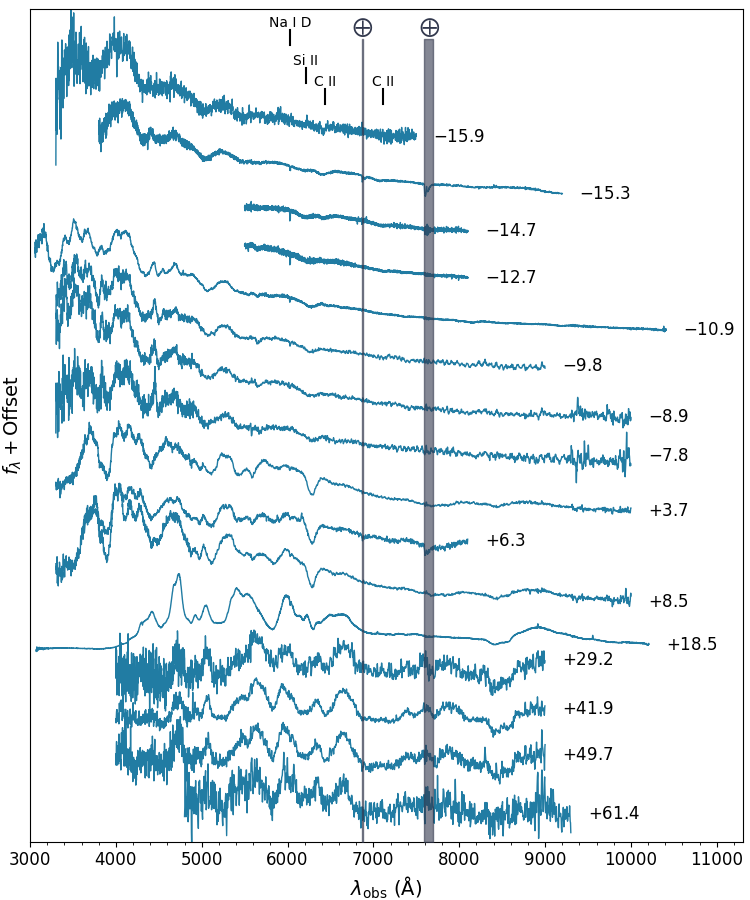

In [238]:
fig = plt.figure(figsize=(7.5, 9))
ax = fig.add_subplot(1, 1, 1)
offset = 0
for spec in spectra:
    if spec.telescope in ["VLT"]:
        continue
    phase = (spec.MJD - T_MAX)/(1+z)
    spec.plot(ax, offset=offset, color="#217CA3", lw = 1)
    ax.text(spec.data["wavelength"][-1] + 200,
            np.median(spec.data["flux"][-20:-1]) + offset, 
            "$%+5.1f$" % phase,
            fontsize=12,
            verticalalignment="center")
    offset += -1.5
ax.set_xlim(3000, 11300)
ax.set_ylim(-23, 5)
ax.xaxis.set_minor_locator(MultipleLocator(200))
# ax.xaxis.set_major_locator(MultipleLocator(500))

# telluric bands
y1, y2 = plt.ylim()
ax.fill_between(x=[7594, 7700], y1=y1, y2=y2 - 1, color="#32384D", alpha=0.6, zorder=9)
ax.fill_between(x=[6867, 6884], y1=y1, y2=y2 - 1, color="#32384D", alpha=0.6, zorder=9)
ax.text(6876, y2 - 1, "$\\bigoplus$", color="#32384D", va="bottom", ha="center")
ax.text(7655, y2 - 1, "$\\bigoplus$", color="#32384D", va="bottom", ha="center")

# Na I D
z = 0.0234
wv = 5890 * (1 + z)
# ax.fill_between(x=[wv - 5, wv + 5], y1=y1, y2=y2 - 1, color='orange', alpha=0.8, zorder=1)
ax.text(wv, y2 - .7, "Na I D", va="bottom", ha="center")
ax.plot([wv,wv], [y2 - .7, y2 - 1.2], "k")

# Si II
wv = 6070 * (1 + z)
ax.text(wv, y2 - 2, "Si II", va="bottom", ha="center")
ax.plot([wv,wv], [y2 - 2, y2 - 2.5], "k")

# C II
wv = 6295 * (1 + z)
ax.text(wv, y2 - 2.7, "C II", va="bottom", ha="center")
ax.plot([wv,wv], [y2 - 2.7, y2 - 3.2], "k")

wv = 6945 * (1 + z)
ax.text(wv, y2 - 2.7, "C II", va="bottom", ha="center")
ax.plot([wv,wv], [y2 - 2.7, y2 - 3.2], "k")

ax.set_xlabel("$\lambda_\mathrm{obs}$ ($\\rm{\\AA}$)", fontsize=14)
ax.set_ylabel("$f_\\lambda + \\rm{Offset}$", fontsize=14)
ax.set_yticks([])
ax.tick_params(axis='x', which='major', labelsize=12)

fig.subplots_adjust(left = 0.04, right = 0.99, top = 0.99, bottom = 0.065)
# plt.savefig("spectra.pdf")

In [53]:
# prepare the observing log table
print("""\
\\begin{deluxetable*}{cccccc}
  \\tablecaption{Spectroscopic observations of iPTF16abc \\label{tab:spec_obs_log}}
  \\tablehead{
    \\colhead{Observation MJD} & \\colhead{SN phase} & \\colhead{Telescope} &
    \\colhead{Instrument} & \\colhead{Wavelength Coverage (\\AA)}
  }
  \\startdata\
""")

for spec in spectra:
    print("    $%8.2f$ & $%+5.1f$ & %s & %s & $%i$--$%i$ \\\\" %\
        (spec.MJD, (spec.MJD - T_MAX)/(1+z), spec.telescope, spec.instrument, 
         int(spec.data["wavelength"].min()),
         int(spec.data["wavelength"].max())) )
        
print("""\
  \\enddata
\\end{deluxetable*}\
""")

\begin{deluxetable*}{cccccc}
  \tablecaption{Spectroscopic observations of iPTF16abc \label{tab:spec_obs_log}}
  \tablehead{
    \colhead{Observation MJD} & \colhead{SN phase} & \colhead{Telescope} &
    \colhead{Instrument} & \colhead{Wavelength Coverage (\AA)}
  }
  \startdata
    $57483.26$ & $-15.9$ & DCT & DeVeny & $3301$--$7499$ \\
    $57483.88$ & $-15.3$ & Gemini-North & GMOS & $3800$--$9200$ \\
    $57484.51$ & $-14.7$ & Keck-II & DEIMOS & $5500$--$8099$ \\
    $57486.51$ & $-12.7$ & Keck-II & DEIMOS & $5500$--$8099$ \\
    $57488.38$ & $-10.9$ & Keck-I & LRIS & $3055$--$10411$ \\
    $57489.51$ & $ -9.8$ & LCOGT-2m & FLOYDS & $3301$--$8999$ \\
    $57490.40$ & $ -8.9$ & LCOGT-2m & FLOYDS & $3301$--$9999$ \\
    $57491.55$ & $ -7.8$ & LCOGT-2m & FLOYDS & $3300$--$9998$ \\
    $57492.20$ & $ -7.2$ & VLT & X-shooter & $3300$--$24550$ \\
    $57494.00$ & $ -5.4$ & VLT & UVES & $4014$--$6039$ \\
    $57503.32$ & $ +3.7$ & LCOGT-2m & FLOYDS & $3300$--$9999$ \\
    $57506.00$ & $ +6

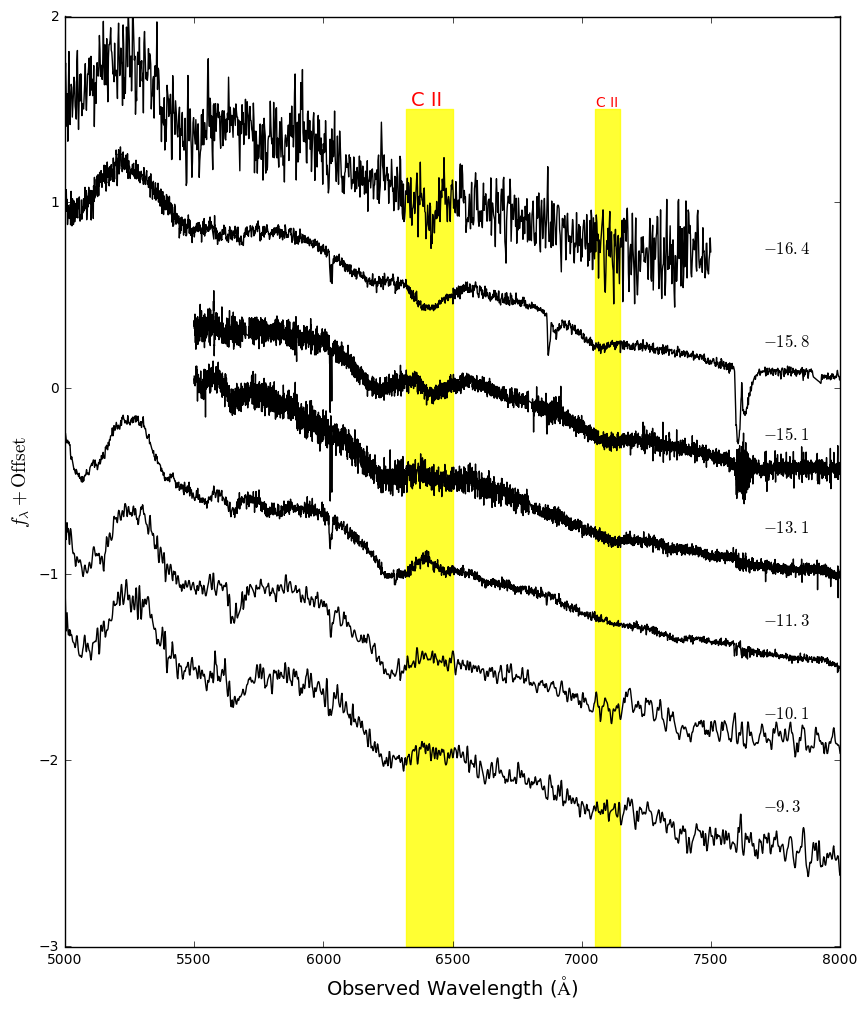

In [97]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)
offset = 0
for spec in spectra:
    if spec.telescope in ["P60", "VLT"]:
        continue
    if spec.MJD - T_MAX > -9:
        break
    phase = spec.MJD - T_MAX
    spec.plot(ax, offset=offset, color='k')
    ax.text(7700,
            0.75 + offset, 
            "$%+5.1f$" % phase,
            fontsize=12,
            verticalalignment="center")
    offset += -0.5
ax.set_xlim(5000, 8000)
ax.set_ylim(-3, 2)

# Carbon features
y1, y2 = plt.ylim()
plt.fill_between(x=[6320, 6500], y1=y1, y2=y2 - 0.5, color='yellow', alpha=0.8, zorder=1)
plt.fill_between(x=[7050, 7150], y1=y1, y2=y2 - 0.5, color='yellow', alpha=0.8, zorder=1)
plt.text(6400, y2 - 0.5, "C II", fontsize=14, color="red", verticalalignment="bottom", horizontalalignment="center")
plt.text(7100, y2 - 0.5, "C II", color="red", verticalalignment="bottom", horizontalalignment="center")

plt.xlabel("Observed Wavelength ($\\rm{\\AA}$)", fontsize=14)
plt.ylabel("$f_\\lambda + \\rm{Offset}$", fontsize=14)
# plt.savefig("CarbonFeature.pdf")